<a href="https://colab.research.google.com/github/thanhyx4/dns-detect-anomaly/blob/main/qlad_gloabal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from math import log10
import numpy as np
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

import logging
import sys
import os.path

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s: %(message)s', datefmt='%d-%m-%Y %H:%M')
ch.setFormatter(formatter)
logger.addHandler(ch)

In [2]:
dtype1={'id': 'Int64',
 'time': 'Int64',
 'domainname': 'str',
 'ttl': 'float16',
 'ipv':'category', 'prot':'category',
 #'src','srcp','dst', 'dstp', asn
 'aa' :'category', 'tc':'category', 'rd':'category', 'ra':'category', 'z':'category', 'ad':'category', 'cd':'category',
  'q_tc':'category', 'q_ra':'category', 'q_ad':'category',
 'ancount': 'Int8', 'arcount': 'Int8', 'nscount': 'Int8', 'qdcount': 'Int8',
 'opcode': 'Int8', 'rcode': 'Int8',
 'qtype': 'float16', 'qclass' : 'float16',
'country':'str', 'asn':'float16', 'asn_organisation':'str',
'edns_udp':'float16', 'edns_version':'category', 'edns_do':'category',  'edns_other':'float16',
'edns_client_subnet': 'str', 'edns_client_subnet_asn':'str', 'edns_client_subnet_asn_organisation':'str', 'edns_client_subnet_country':'str',
 'labels': 'Int8',
 'proc_time': 'float32',
 'q_tc':'str', 'q_ra':'str', 'q_ad':'str',
 'pub_resolver': 'str',
 'req_len': 'float16', 'res_len': 'float16',
 'tcp_hs_rtt': 'float',
 'req_ip_df': 'str',
 'year': 'Int16', 'month': 'Int8', 'day':'Int8',
 'server': 'str',
 'qname': 'str',
  }
result3use_columns = [
 'time',  'ttl',  'proc_time',
 'domainname',
  'ipv', 'prot',
 'src','srcp','dst', 'dstp',
 'opcode', 'rcode',
 'qtype', 'qclass',  'qname',
 'country', 'asn', 'asn_organisation',
 'pub_resolver',
 'req_len', 'res_len',
 'server',
]

In [42]:
#read data
dns_traffic = pd.read_csv("/content/drive/MyDrive/result24.csv", sep ='\t', on_bad_lines = "warn", dtype = dtype1, usecols = result3use_columns)     #300mb = 2 hours


<Axes: ylabel='Queries per second'>

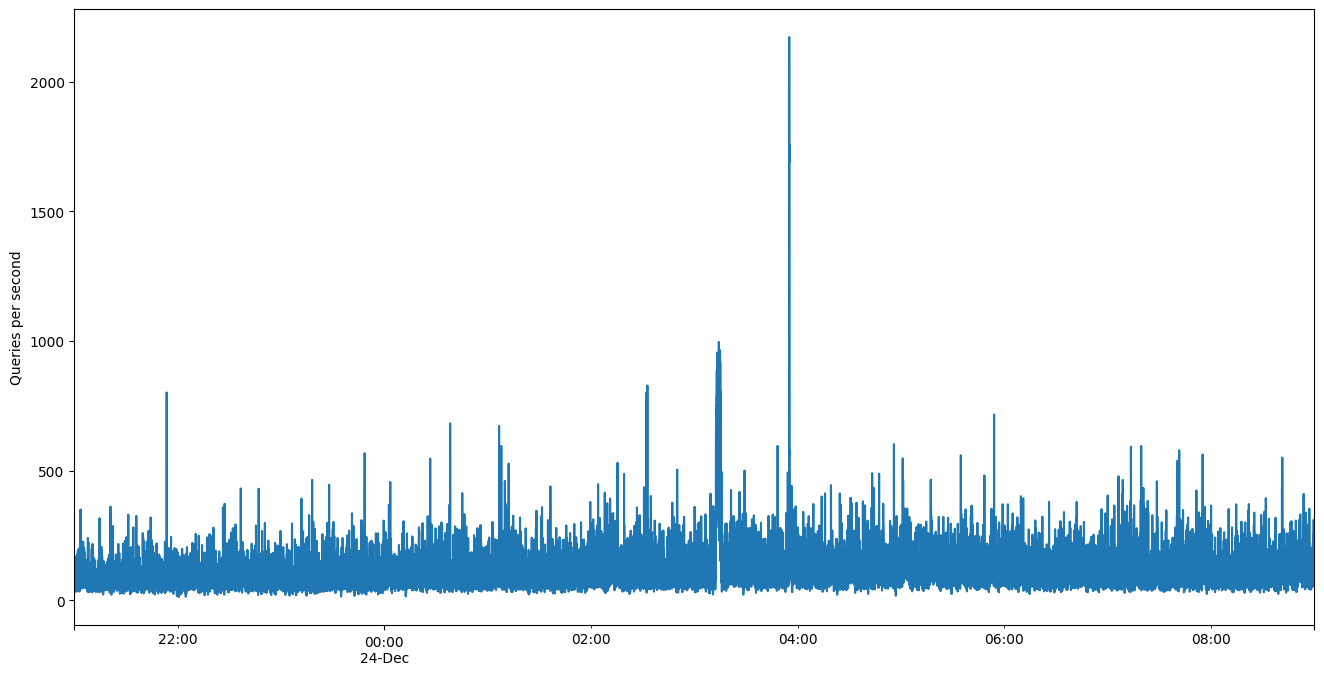

In [39]:
def add_datetime(dns_traffic):
  dns_traffic['datetime'] = pd.to_datetime(dns_traffic['time'], unit ='ms')
  dns_traffic['datetime'] = dns_traffic['datetime'].dt.floor('s')
  dns_traffic['epoch_time'] =dns_traffic['time']/ 1000
  #dns_traffic['time'] = dns_traffic['datetime'].dt.time
  return dns_traffic

dns_traffic = add_datetime(dns_traffic)
#chuan bi du lieu theo phut
dns_traffic['datetime_minute'] = dns_traffic['datetime'].dt.floor('s')
dns_traffic['datetime'].value_counts().sort_index().plot(kind = 'line', figsize=(16,8), ylabel = 'Queries per second')

#I. EMA filter

In [33]:
class EMA(object):
    w = 0.5
    ema = 0
    ems = 0

    def __init__(self, w, ema=0, ems=0):
        self.w = w
        self.ema = ema
        self.ems = ems

    def update_ema(self, x):
        self.ema = self.w * self.ema + (1 - self.w) * x

    def update_ems(self, x):
        self.ems = self.w * self.ems + (1 - self.w) * ((x - self.ema)**2)

    def update(self, x):
        self.update_ems(x)
        self.update_ema(x)
        return (self.ema, self.ems)

    def is_anomaly(self, x, threshold):
        return abs(x - self.ema) > threshold * np.sqrt(self.ems)

def ema_save(model, id):
    with open('EMA_{}.model'.format(id), 'wb') as output:
        pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

def ema_load(id):
    if not os.path.isfile('EMA_{}.model'.format(id)):
        return EMA(0.99, ema=0.5, ems=0.01)
    with open('EMA_{}.model'.format(id), 'rb') as input:
        return pickle.load(input)


#II. Main

In [ ]:
def fetch_data(features, begin, end, server):
    conn = connect(host=IMPALA_HOST, port=IMPALA_PORT)
    cur = conn.cursor()
    histograms = []
    for feature in features:
        sql="SELECT {0}, count({0}) AS cnt FROM dns.staging WHERE unixtime >= {1} AND unixtime < {2} AND server = '{3}' GROUP BY {0}".format(feature, begin, end, server)
        logger.debug("Executing sql: " + sql )
        cur.execute(sql)
        logger.debug("Get description of results returned by impala query for feature:" + str(feature) + str(cur.description))
        output=cur.fetchall()
        logger.debug("length of output of impala query for " + feature + ":" + str(len(output)))
        histograms.append(output)
    conn.close()
    return histograms

def entropy(histogram):
    """ Computes the normalized entropy of a histogram. """
    total = sum([bin[1] for bin in histogram])
    if total == 0:
        return 0.0

    entropy = 0.0
    for bin in histogram:
        if bin[1] > 0:
            entropy -= (bin[1]/total)*log10(bin[1]/total)

    # clip small negative values
    if entropy < 0:
        return 0.0
    return entropy / log10(len(histogram))


  def main():
    features = ['domainname', 'qtype', 'src', 'rcode', 'asn', 'country', 'res_len']
    #features = ['rcode']
    documents = []

    last_ts = get_last_ts(options.server)
    begin = options.begin
    end = begin + options.window
    while end < last_ts:
        # Fetch data from impala
        logger.info("Fetching data for {} between {} and {}. Last TS in impala is {}"
                     .format(options.server, datetime.fromtimestamp(begin), datetime.fromtimestamp(end), datetime.fromtimestamp(last_ts)))
        histograms = fetch_data(features, begin, end, options.server)
        entropies = [entropy(histogram) for histogram in histograms]
        # Detect anomalies in fetched data
        logger.info("Detecting anomalies for {} between {} and {}."
                     .format(options.server, datetime.fromtimestamp(begin), datetime.fromtimestamp(end)))
        anomalies = []
        for feature, ent in zip(features, entropies):
            anomaly = detect_anomaly(feature, ent, options.server, options.threshold)
            if anomaly is not None:
                anomalies.append({ 'feature': feature, 'score': anomaly })
        # Create a mongoDB document for the data and anomalies
        documents.append(to_document(begin, end, options.server, features, histograms, anomalies))
        # Go to the next window
        begin = end
        end = begin + options.window
    # Store everything in the mongoDB database
    store_in_mongoDB(documents)
    # print(json.dumps(documents))
    print("Start next execution with --begin {}".format(begin))

def store_in_mongoDB(documents):
    if len(documents):
        client = MongoClient(host=[MONGO_HOST])
        db = client[MONGO_DB]
        result = db.dnsstats.insert_many(documents)
        if result:
            logger.info("Successfully saved {} windows.".format(len(documents)))
    else:
        logger.info("No new windows found.")



In [ ]:
def to_document(start, end, server, features, histograms, anomalies):
    document = {}
    document['start'] = start
    document['end'] = end
    document['server'] = server
    #logger.debug("To document for  features:" + str(features) + " histograms:" + str(histograms) )
    #logger.debug("ZIP" + str(zip(features, histograms)) )
    #CONTENT OF features en histograms
    #Histogram is list of histograms. histogram[0] is histogram for first feature in list "features", histogram[1} is histogram for second feature in list "features" and so on
    #(zip(features, histograms))
    #RESULT FROM ZIP  ZIP[('rcode', [(3, 26204), (5, 19), (4, 2), (9, 1), (-1, 26), (0, 50514), (1, 1)]),(qtype,[('......]
    logger.debug("Length of array of array of histograms is " +  str(len(histograms)))
    for feature, histogram in zip(features, histograms):
        #logger.debug("To document for  feature:" + str(feature) + " histogram:" + str(histogram) )
        logger.debug("histogram of feature " +  str(feature) + " contains " + str(len(histogram))  + " (value of " + str(feature) + ":count of " + str(feature) + ") tuple pairs")
        #Quick & dirty workaround for now, sometimes we get an empty histogram probably due to timestamp where we want to query is in the future sometimes?
        #This is crashing this script so prevent crashing
        if str(len(histogram)) == "0":
          logger.debug("Length of histogram is 0, activating quick workaround of setting max min and avg to 0 for this window")
          document[feature] = {
            'histogram': histogram_to_document(histogram),
            'entropy': entropy(histogram),
            'max': 0,
            'min': 0,
            'avg': 0
          }
        else:
          document[feature] = {
            'histogram': histogram_to_document(histogram),
            'entropy': entropy(histogram),
            'max': max([bin[1] for bin in histogram]),
            'min': min([bin[1] for bin in histogram]),
            'avg': sum([bin[1] for bin in histogram])/len(histogram)
          }
    document['nb_queries'] = sum([bin[1] for bin in histograms[0]])
    document['anomalies'] = anomalies
    return document

In [34]:
def detect_anomaly(feature, entropy, server, threshold=3):
    filter_id =  "%s_%s" % (server, feature)
    filt = ema_load(filter_id)
    newEMA, newEMS = filt.update(entropy)
    filt = EMA(0.99, newEMA, newEMS)
    ema_save(filt, filter_id)
    if filt.is_anomaly(entropy, threshold):
        return newEMS
    else:
        return None

In [44]:
window = 60*5*1000 #mili seconds
threshold = 3.0     #default

def fetch_data_csv(features, begin, end, server):

    histograms = []
    if server:
      for feature in features:
          output = dns_traffic.loc[(dns_traffic['server'] == server) & (dns_traffic['time'] >= begin) & (dns_traffic['time'] <= end), feature].value_counts()

          histograms.append(output)
    #else:

    return histograms

def entropy_csv(histogram):
    """ Computes the normalized entropy of a histogram. """
    total = sum([bin for bin in histogram])
    if total == 0:
        return 0.0

    entropy = 0.0
    for bin in histogram:
        if bin > 0:
            entropy -= (bin/total)*log10(bin/total)

    # clip small negative values
    if entropy < 0:
        return 0.0
    return entropy / log10(len(histogram))

def main_csv():
  features = ['domainname', 'qtype', 'src', 'rcode', 'asn', 'country', 'res_len']
  documents = []
  servers = dns_traffic['server'].unique()

  last_ts = dns_traffic['time'].max()
  begin = dns_traffic['time'].min()
  end = begin + window
  while end < last_ts:
    histograms = fetch_data_csv(features, begin, end, servers[0])
    entropies = [entropy_csv(histogram) for histogram in histograms]

    anomalies = []
    for feature, ent in zip(features, entropies):
      anomaly = detect_anomaly(feature, ent, server[0], threshold)
      if anomaly is not None:
            anomalies.append({ 'feature': feature, 'score': anomaly })

    #documents.append(to_document(begin, end, server[0], features, histograms, anomalies))
    # Go to the next window
    begin = end
    end = begin + window
    if anomalies:
      print("time begin: " + str(begin))
      print(histograms)
      print("time end" + str(end))
      print(anomalies)


main_csv()

time begin: 1703387700000
[203.in-addr.arpa                                   30643
vnnic.vn                                            8075
i-speed.vn                                           553
42.in-addr.arpa                                      433
vnnic.net.vn                                         366
tenmien.vn                                           221
117.in-addr.arpa                                     102
2.ip6.arpa                                            81
speedtest.vn                                          51
202.in-addr.arpa                                      18
aptld71.vn                                            15
bind                                                  11
domain.vn                                              9
vnix.vn                                                8
tenmientiengviet.vn                                    7
ipv6launch.vn                                          5
internet-conference.vn                                 4
vnix

In [43]:
#test
servers = dns_traffic['server'].unique()
begin = dns_traffic['time'].min()
end = begin + window

server = servers[0]
features = ['domainname', 'qtype', 'src', 'rcode', 'asn', 'country', 'res_len']

#output = dns_traffic.loc[(dns_traffic['server'] == server) & (dns_traffic['time'] >= begin) & (dns_traffic['time'] <= end), 'rcode'].value_counts()




histograms = fetch_data_csv(features, begin, end, servers[0])
entropies = [entropy_csv(histogram) for histogram in histograms]

anomalies = []
for feature, ent in zip(features, entropies):
    anomaly = detect_anomaly(feature, ent, server[0], threshold)
    if anomaly is not None:
            anomalies.append({ 'feature': feature, 'score': anomaly })

anomalies

[]

#III. Kalman filter

In [ ]:
def plot_filter(plt, xs, ys=None, c='#013afe', label='Filter', var=None, **kwargs):

    if ys is None:
        ys = xs
        xs = range(len(ys))

    plt.plot(xs, ys, color=c, label=label, **kwargs)

    if var is None:
        return

    var = np.asarray(var)

    std = np.sqrt(var)
    std_top = ys+std
    std_btm = ys-std

    plt.plot(xs, ys+std, linestyle=':', color='k', lw=2)
    plt.plot(xs, ys-std, linestyle=':', color='k', lw=2)
    plt.fill_between(xs, std_btm, std_top, facecolor='yellow', alpha=0.2)
